# Overview of Labels and Images

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image

## Labels Data Overview

In [6]:
labels = pd.read_csv('../raw_data/train_labels.csv')

In [7]:
labels.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [8]:
print(f"number of labelled images: {labels['id'].nunique()}")

number of labelled images: 220025


In [9]:
labels.groupby(by='label').count()

,id
label,
0,130908
1,89117


## Moving images into sub-folders

In [10]:
import os
import shutil
from os.path import exists

In [11]:
# Path where images need to be moved
full_path = '/Users/chloeguillaume/code/GuillaumeRib/project-cancer-detection/raw_data/train'
# NEED to MANUALLY change the root and MANUALLY create first '0' and '1' sub-folders within this folder.

# Set the dataframe of images <=> labels: train_labels.csv
labels = pd.read_csv('../raw_data/train_labels.csv')

In [14]:
# Function to move files into 0 and 1 sub-folders within your full_path folder
def move_to_subfolders(full_path,labels):
    for index,row in labels.reset_index().iterrows():
        file = row['id']
        folder = str(row['label'])
        source_path = os.path.join(full_path,file+'.tif')
        if exists(source_path) is True:
            destination_path = os.path.join(full_path,folder,file+'.tif')
            shutil.move(source_path,destination_path)
    return None

In [15]:
# Uncomment to execute function
#move_to_subfolders(full_path,labels)

## Check an image name / id class

In [16]:
# Check if image is in 0 or 1:
label_0=labels[labels['label']==0]
label_1=labels[labels['label']==1]

image_to_test = 'fff4fbf5b7a8a944c4720d1f7bd094e5047e7e7d'
print(f"image is Cat 0: {image_to_test in list(label_0['id'])}")
print(f"image is Cat 1: {image_to_test in list(label_1['id'])}")

image is Cat 0: True
image is Cat 1: False


# TF Image Data Generator

## Train / Test set paths

In [17]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../raw_data/train'
local_test_path = '../raw_data/testGUI'

## Setup

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

In [20]:
# Load from directory to flow passsed into ImageGenerator - Set train / val / test splits
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    batch_size=16,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  class_mode='binary')

Found 140818 images belonging to 2 classes.
Found 35203 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


## Overview of images generators

In [21]:
print(type(train_generator))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [22]:
print(type(train_generator[0][0]))

<class 'numpy.ndarray'>


In [23]:
print(type(train_generator[0]))

<class 'tuple'>


In [24]:
# Example of classes from 1 batch
print(train_generator[1][1])

[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.]


In [25]:
# batch_size
print(train_generator[0][1].shape)

(16,)


In [26]:
# image shape
train_generator.image_shape

(96, 96, 3)

### Checking balance of data

In [27]:
# Checking balance of data in TRAIN split
train_lab_df = pd.DataFrame(train_generator.classes,columns=['class'])
train_lab_df.value_counts()

class
0        83782
1        57036
dtype: int64

In [28]:
# Checking balance of data in VALIDATION split
val_lab_df = pd.DataFrame(val_generator.classes,columns=['class'])
val_lab_df.value_counts()

class
0        20945
1        14258
dtype: int64

In [29]:
# Checking balance of data in TEST split
test_lab_df = pd.DataFrame(test_generator.classes,columns=['class'])
test_lab_df.value_counts()

class
0        26181
1        17823
dtype: int64

# CNN Model

## Model Design and Init function

In [109]:
# INIT MODEL and COMPILE
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def init_model():
    model = models.Sequential()
    
    model.add(Rescaling(scale=1./255,input_shape=(96,96,3)))

    # Lets add convolution layers, 
    model.add(layers.Conv2D(32, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling2D(2))
  
    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))


    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation='relu'))
  
    model.add(layers.Dense(1, activation='sigmoid'))

     ### Model compilation
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

## Summary

In [110]:
model = init_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 95, 95, 32)        416       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 46, 46, 32)        4128      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 22, 32)       

## Model Training

In [111]:
from tensorflow.keras.callbacks import EarlyStopping

### Fitting the model

In [112]:
model = init_model()
epochs = 1
batch_size = 32
es = EarlyStopping(patience=3, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

400/400 [==============================] - 53s 131ms/step - loss: 0.6692 - accuracy: 0.5681 - val_loss: 0.6944 - val_accuracy: 0.5000


### Plot the loss curves train vs val

In [34]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

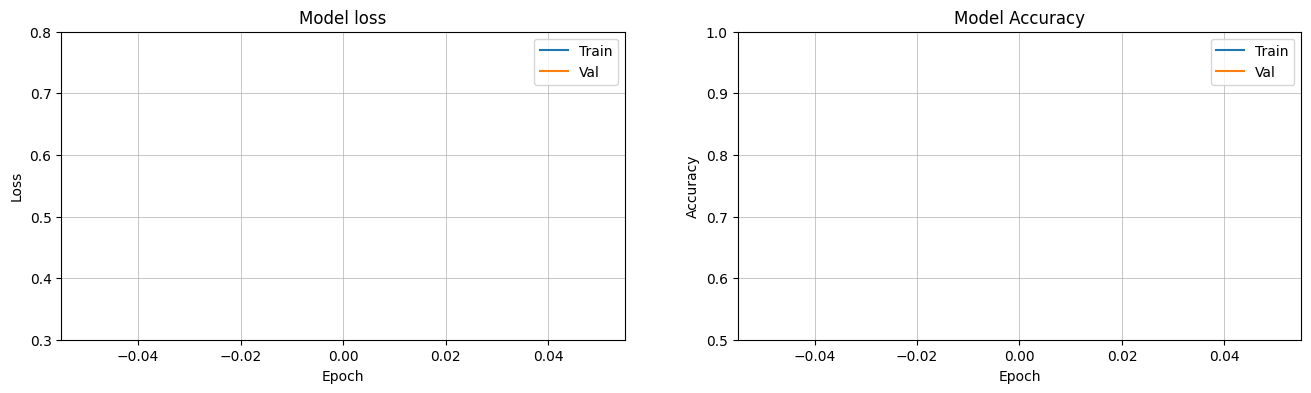

In [35]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

## Model Evaluation

In [80]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

1/1 [==============================] - 0s 76ms/step - loss: 1.1872 - accuracy: 0.0000e+00
The accuracy on the test set is of 0.00 %


In [61]:
results

[0.5510472059249878, 0.5]

In [81]:
model.predict(test_generator)

1/1 [==============================] - 0s 84ms/step


array([[0.7811414],
       [0.5747574]], dtype=float32)

In [64]:
model.predict_classes(test_generator)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [65]:
model.predict(

AttributeError: 'Sequential' object has no attribute 'predict_proba'